# Libraries and Load Data

In [2]:
import numpy as np
import pandas as pd
from prophet import Prophet

In [3]:
df = pd.read_csv('Udemy_wikipedia_visits.csv')
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


In [5]:
#Summary Statistics
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


<Axes: >

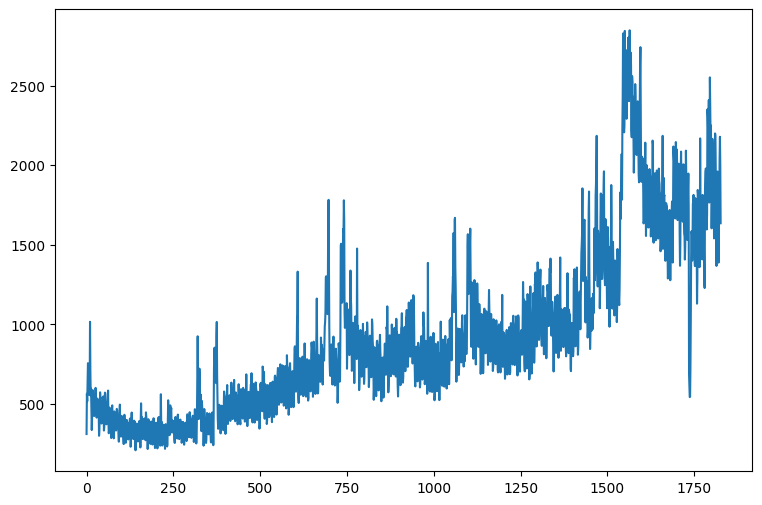

In [6]:
#Plotting
df.Udemy.plot(figsize=(9,6))

# Data Preparation

In [7]:
#Date Variable
df.Date = pd.to_datetime(df.Date,
                        format = "%m/%d/%Y")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


In [8]:
#Change Variable: Date -> ds, time-series (Udemy) -> y
df = df.rename(columns = {'Date': 'ds',
                         'Udemy': 'y'})
df.head(1)

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0


# Holidays

In [9]:
#Easter Holiday
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [10]:
#Black Friday
bf_dates = pd.to_datetime(df[df['Black Friday'] == 1].ds)
bf = pd.DataFrame({'holiday': 'black_friday',
                   'ds': bf_dates,
                   'lower_window': -7,
                   'upper_window': 5})

In [11]:
#Combine the holidays
holidays = pd.concat([easter, bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [12]:
#Remove holidays from the main df
df = df.drop(columns = ['Easter', 'Black Friday'])
df.head()

,ds,y,Christmas
0,2016-01-01,311,0
1,2016-01-02,564,0
2,2016-01-03,517,0
3,2016-01-04,652,0
4,2016-01-05,756,0


# Prophet Model

In [13]:
#Training and Test Split
test_days = 31
training = df.iloc[:-test_days,:]
test = df.iloc[-test_days:, :]
print(test.head(1))
print(training.tail(1))

             ds     y  Christmas
1796 2020-12-01  2393          0
             ds     y  Christmas
1795 2020-11-30  2551          0


In [14]:
#Prophet Model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'additive',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale= 0.05)
m.add_regressor('Christmas', mode = 'multiplicative')
#m.add_regressor('XXXX')
m.fit(training)

16:40:50 - cmdstanpy - INFO - Chain [1] start processing
16:40:50 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
#Regressor coefficients
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.328282,-0.328282,-0.328282


## Forecasting 

In [16]:
#Create future dataframe
future = m.make_future_dataframe(periods = test_days,
                       freq = 'D')

future = pd.concat([future, df.iloc[:, 2:]],
                  axis = 1)

future

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0


In [17]:
#forecastiing
forecast = m.predict(future)
forecast.head()
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'black_friday',
       'black_friday_lower', 'black_friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


In [18]:
#Holiday Assessment
holiday = 'black_friday'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]

,ds,black_friday
1785,2020-11-20,89.925057
1786,2020-11-21,81.105621
1787,2020-11-22,155.277942
1788,2020-11-23,227.437720
1789,2020-11-24,203.828403
1790,2020-11-25,174.334621
1791,2020-11-26,214.309064
1792,2020-11-27,447.109962
1793,2020-11-28,192.999554
1794,2020-11-29,217.827102


In [19]:
forecast.yhat[-test_days:]

1796    2491.907773
1797    2358.228863
1798    2076.864828
1799    1976.176170
1800    1810.261491
1801    1842.389518
1802    2050.311377
1803    2069.049387
1804    2053.237784
1805    2023.377586
1806    1923.321811
1807    1760.033175
1808    1796.807514
1809    2011.377751
1810    2038.701765
1811    2033.303285
1812    2015.528054
1813    1929.031444
1814    1780.539636
1815    1833.077541
1816    2064.078178
1817    2108.176775
1818    2119.558553
1819    2118.222298
1820    1365.740086
1821    1913.704551
1822    1979.608300
1823    2222.317304
1824    2276.194026
1825    2295.187467
1826    2299.102582
Name: yhat, dtype: float64

In [20]:
#retrieve the predictions
predictions = forecast.yhat[-test_days:]

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

187.58269407653538
238.92892163020096


## Visualization

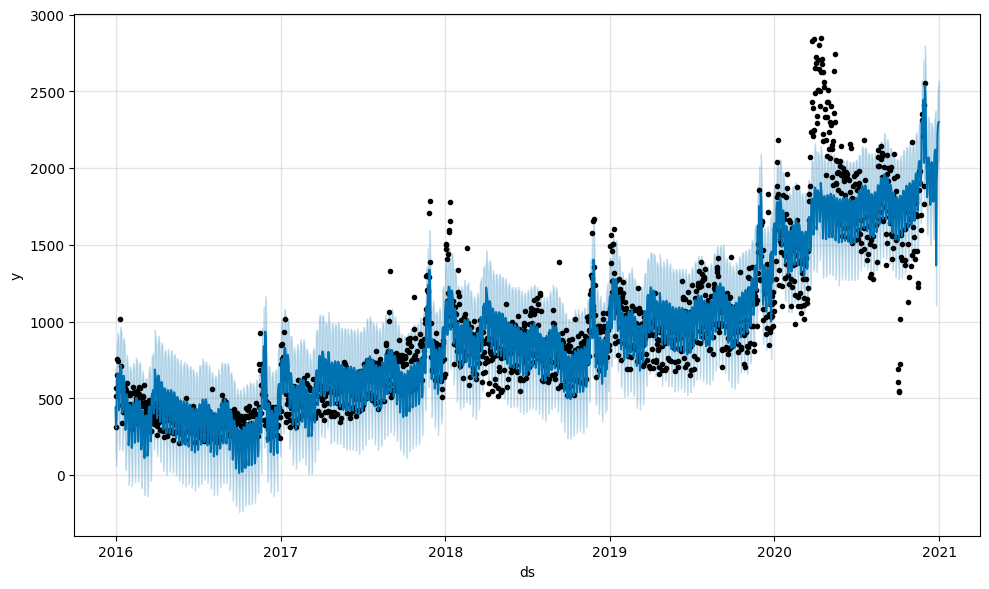

In [22]:
#Visualize the forecast
m.plot(forecast);

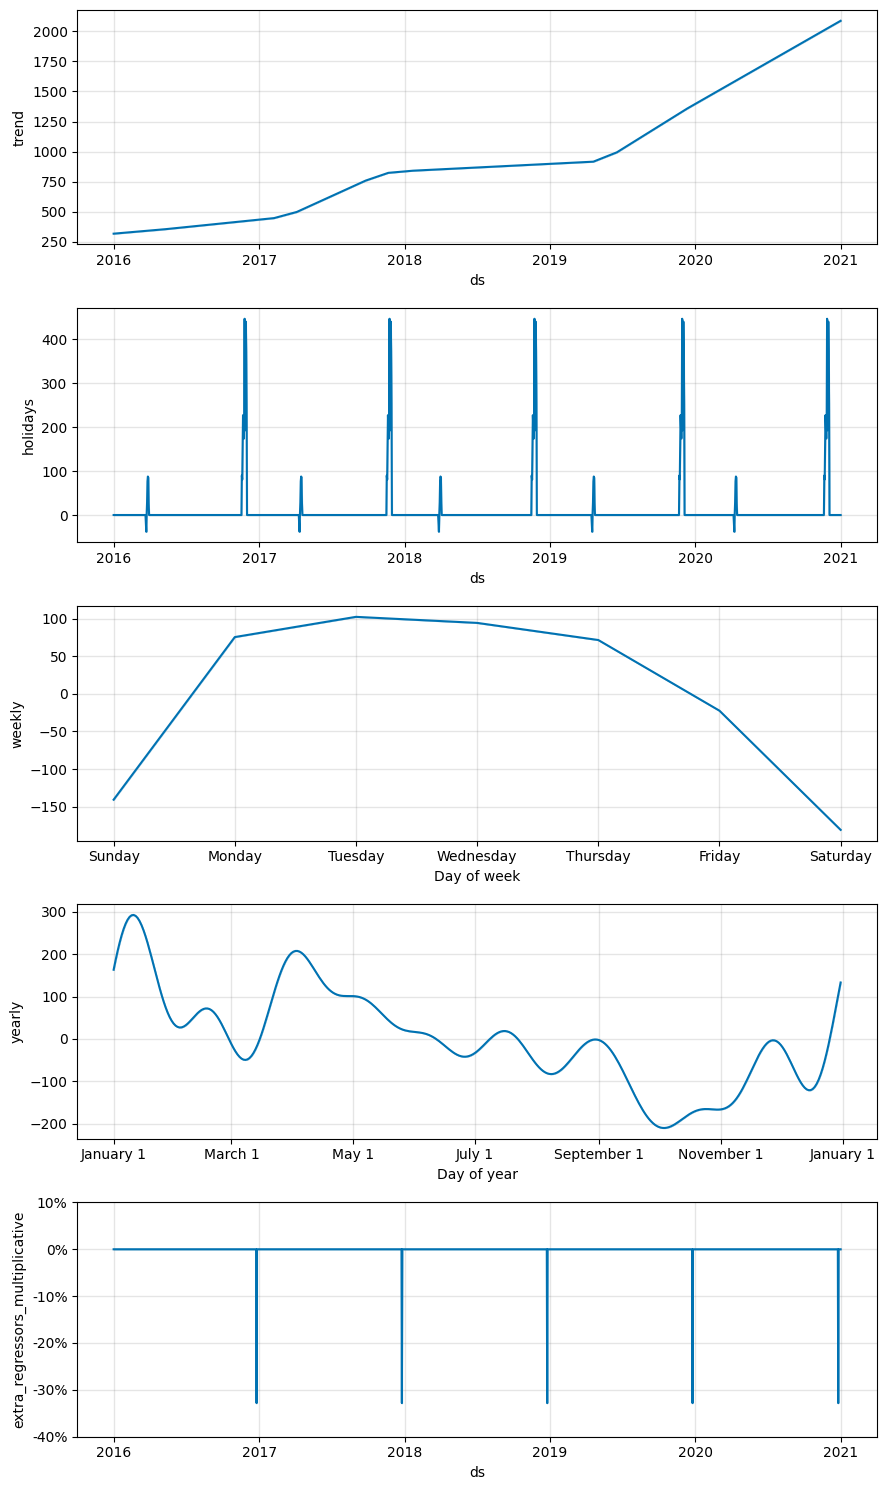

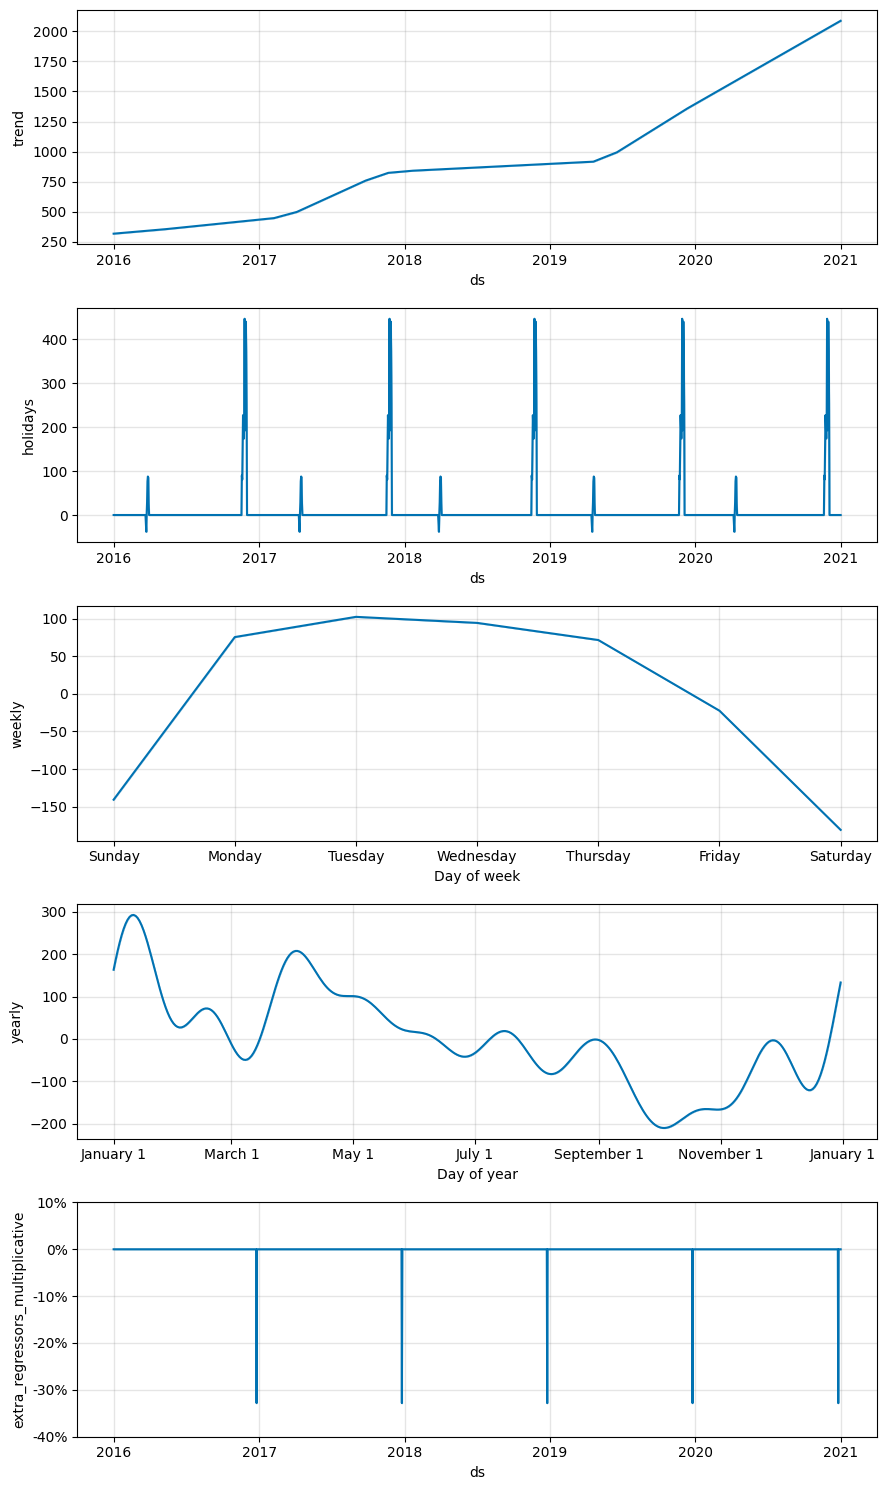

In [23]:
#plot components -> Structural Time Series decomposition
m.plot_components(forecast)

## Cross Validation

In [24]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '1450 days', #365 days
                         parallel = 'processes')

In [25]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1282.756935,1135.504487,1416.433619,1165,2019-12-25
1,2019-12-27,1224.139618,1085.721708,1353.402141,1111,2019-12-25
2,2019-12-28,1102.805229,971.297224,1232.679210,1038,2019-12-25
3,2019-12-29,1164.664311,1034.989925,1306.280701,971,2019-12-25
4,2019-12-30,1373.209792,1243.107607,1497.498267,1192,2019-12-25


In [26]:
#Error assesment
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

400.4219381314898
518.3567575494878


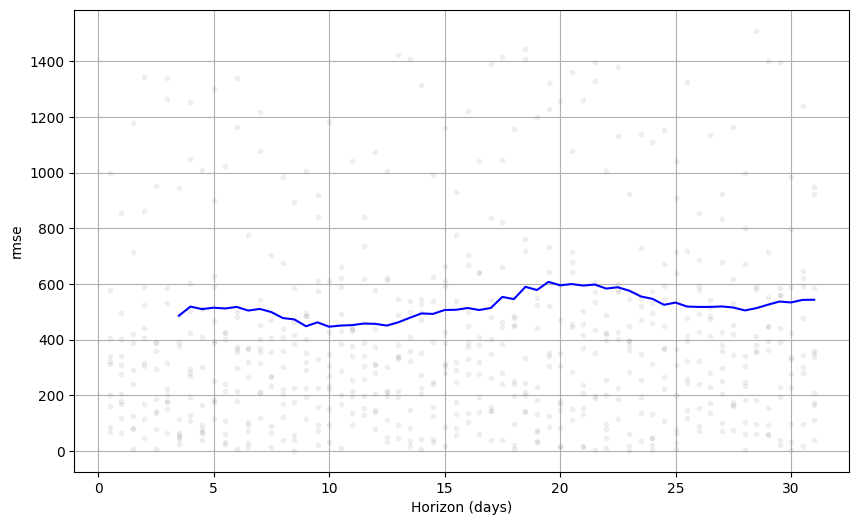

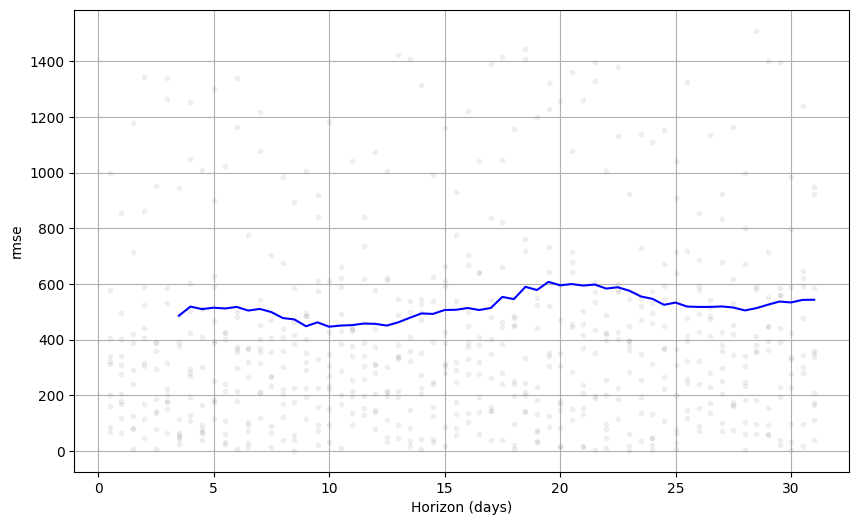

In [27]:
#CV Visualization
from prophet.plot import plot_cross_validation_metric as pc
pc(df_cv,
  metric = 'rmse')

## Parameter Tuning

In [28]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
             'seasonality_prior_scale': [5, 10, 20],
             'holidays_prior_scale': [5, 10, 20],
             'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

54

In [29]:
#Empty list to store results
rmsa = []

#start the loop
for i in grid:
    #build the model
    m = Prophet(growth = 'linear',
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
            holidays = holidays,
           seasonality_mode = i['seasonality_mode'],
           seasonality_prior_scale = i['seasonality_prior_scale'],
           holidays_prior_scale = i['holidays_prior_scale'],
           changepoint_prior_scale = i['changepoint_prior_scale'])

    m.add_regressor('Christmas', mode = 'multiplicative')
    m.fit(training)
    
    #Cross-Validation
    df_cv = cross_validation(m,
                            horizon = '31 days',
                            initial = '1450 days',
                            parallel = 'processes')
    
    #Measure and store results
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    rmsa.append(error)

16:40:59 - cmdstanpy - INFO - Chain [1] start processing
16:40:59 - cmdstanpy - INFO - Chain [1] done processing
16:41:03 - cmdstanpy - INFO - Chain [1] start processing
16:41:04 - cmdstanpy - INFO - Chain [1] done processing
16:41:08 - cmdstanpy - INFO - Chain [1] start processing
16:41:08 - cmdstanpy - INFO - Chain [1] done processing
16:41:12 - cmdstanpy - INFO - Chain [1] start processing
16:41:12 - cmdstanpy - INFO - Chain [1] done processing
16:41:17 - cmdstanpy - INFO - Chain [1] start processing
16:41:17 - cmdstanpy - INFO - Chain [1] done processing
16:41:21 - cmdstanpy - INFO - Chain [1] start processing
16:41:22 - cmdstanpy - INFO - Chain [1] done processing
16:41:26 - cmdstanpy - INFO - Chain [1] start processing
16:41:26 - cmdstanpy - INFO - Chain [1] done processing
16:41:30 - cmdstanpy - INFO - Chain [1] start processing
16:41:30 - cmdstanpy - INFO - Chain [1] done processing
16:41:34 - cmdstanpy - INFO - Chain [1] start processing
16:41:35 - cmdstanpy - INFO - Chain [1]

In [30]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmsa
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,511.735307
1,0.01,5,additive,10,514.304889
2,0.01,5,additive,20,512.687536
3,0.01,5,multiplicative,5,529.626266
4,0.01,5,multiplicative,10,530.325641
5,0.01,5,multiplicative,20,529.435288
6,0.01,10,additive,5,512.050367
7,0.01,10,additive,10,512.536266
8,0.01,10,additive,20,511.074722
9,0.01,10,multiplicative,5,530.095823
